# Pipelines

Un Pipeline (o tubería) es un objeto que encadena (o "pasa por una tubería") diversas fases de preprocesamiento y un estimador final. Por ejemplo:

* Transformaciones iniciales (ej. imputación de valores faltantes, escalado de datos, selección de características, etc.).
* Modelo final (ej. una regresión lineal, un clasificador random forest, un SVM, etc.).

Al usar un Pipeline, estas fases se integran en un solo objeto que se entrena y se evalúa de forma conjunta. 

* Ventajas:
    * Se asegura que todas las transformaciones se realicen siempre de la misma forma en entrenamiento y en predicción.
    * Se reduce el riesgo de fugas de información (data leakage).
    * Se simplifica el código y se puede integrar fácilmente con las rutinas de búsqueda de hiperparámetros (e.g. GridSearchCV o RandomizedSearchCV) y validación cruzada.
    
- Función python vs pipeline:
    * Gestionar manualmente el particionado evitando la fuga de datos
    * Aprovecha el polimorfismo ya que todos los preprocesadores de scikit heredan de una clase en común: TransformerMixin por tanto tienen unos métodos comunes: fit, transform y fit_transform
    * Facilita la exportación para usar en producción porque exporta un objeto con todos los preprocesados y modelado incluido
    * Facilita la composición de pasos de forma muy simplificada


* Objetivo:
    * crear un pipeline que tenga preprocesados y modelo y exportarlo. De esta forma si lo cargamos en otro entorno podemos pedirle predicciones sin tener que limpiar / preprocesar los datos, ya hace el propio pipeline.

* Ámbito: lo pipelines están diseñados para transformar la X, es decir lo datos de entrada a través de pasos.
    * Cuando se ejecutan los métodos fit, predict del pipelines no aplican transformaciones a la "y", solo a la "X".
    * Si se quiere modificar la "y" se puede hacer antes de entrenar el pipeline


Clases y métodos de scikit learn:

* Pipeline: 
    * Permite encadenar una secuencia de transformadores y un estimador final.
* make_pipeline: 
    * función para crear un objeto Pipeline sin necesidad de asignar manualmente un nombre a cada paso.

* ColumnTransformer: 
    * Permite aplicar diferentes transformaciones a subconjuntos específicos (por ejemplo, columnas) de un conjunto de datos. Útil para trabajar con datos tabulares que contienen variables de distintos tipos
    * El conjunto de datos completo, pero se especifican columnas específicas para cada transformador.
    * Por ejemplo combinar MinMaxScaler con OneHotEncoding

* FeatureUnion: 
    * Entrada única para todos: Aplica cada transformador de la unión a la misma matriz de entrada completa. Por ejemplo combinar PCA y SelectKBest
* make_union: 
    * Función de ayuda para crear una FeatureUnion de forma automática, similar a make_pipeline

## Clase Pipeline

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = sns.load_dataset('penguins')
df = df.dropna(subset=['body_mass_g']) # quitar nulos de la salida "y" porque es la variable a predecir

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [138]:
# pipeline con 2 pasos
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', LinearRegression()) 
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test) # ya actua como un modelo aunque no lo sea

print(pipeline.named_steps)
print(pipeline.named_steps['imputer'])
print(pipeline.named_steps['model'])

{'imputer': SimpleImputer(strategy='median'), 'model': LinearRegression()}
SimpleImputer(strategy='median')
LinearRegression()


In [139]:
X

,bill_length_mm,bill_depth_mm,flipper_length_mm
0,39.1,18.7,181.0
1,39.5,17.4,186.0
2,40.3,18.0,195.0
4,36.7,19.3,193.0
5,39.3,20.6,190.0
...,...,...,...
338,47.2,13.7,214.0
340,46.8,14.3,215.0
341,50.4,15.7,222.0
342,45.2,14.8,212.0


In [140]:
y

0      3750.0
1      3800.0
2      3250.0
4      3450.0
5      3650.0
        ...  
338    4925.0
340    4850.0
341    5750.0
342    5200.0
343    5400.0
Name: body_mass_g, Length: 342, dtype: float64

In [141]:
X_new = pd.DataFrame([[39.1, 18.7, 181.0]], columns=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'])
pipeline.predict(X_new)

array([3224.93857568])

In [142]:
X_new = pd.DataFrame([[39.1, np.nan, 181.0]], columns=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'])
pipeline.predict(X_new)

array([3209.64419227])

## Método make_pipeline

In [143]:
# Alternativa con método make_pipeline
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    LinearRegression()
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test) # ya actua como un modelo aunque no lo sea

# toma los nombres automáticamente del propio nombre de la clase de cada paso del pipeline
print(pipeline.named_steps)
print(pipeline.named_steps['simpleimputer']) 
print(pipeline.named_steps['linearregression'])

{'simpleimputer': SimpleImputer(strategy='median'), 'linearregression': LinearRegression()}
SimpleImputer(strategy='median')
LinearRegression()


## Pipeline con GridSearchCV

Notación especial `__` para separar los pasos de los parámetros.

In [144]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('transformer', PowerTransformer()),
#    ('scaler', RobustScaler()),
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsRegressor())
  #  ('model', LinearRegression()) 
])

params = {
    'imputer__strategy': ['mean', 'median'],
    'transformer__method': ['yeo-johnson', 'box-cox'],
    'scaler__feature_range': [(0, 1), (0,2)],   # ponemos 2 tuplas de rango
    'model__n_neighbors': np.arange(3, 20)
}

grid = GridSearchCV(pipeline, params, scoring='r2')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print('r2_score', r2_score(y_test, y_pred))
print('grid best params', grid.best_params_)



r2_score 0.8151453148627383
grid best params {'imputer__strategy': 'mean', 'model__n_neighbors': np.int64(11), 'scaler__feature_range': (0, 1), 'transformer__method': 'yeo-johnson'}


In [145]:
X_new = pd.DataFrame([[39.1, np.nan, 181.0]], columns=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'])
grid.predict(X_new)

array([3461.36363636])

In [146]:
# desactivando pasos
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('transformer', PowerTransformer()), # En este ejemplo lo hacemos opcional
    ('scaler', MinMaxScaler()), # En este ejemplo lo hacemos opcional   
    ('model', KNeighborsRegressor())
])
params = {
    'imputer__strategy': ['mean', 'median'],
    'transformer': [None, PowerTransformer(method='yeo-johnson'), PowerTransformer(method='box-cox')],
    'scaler': [None, MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 2))],
    'model__n_neighbors': np.arange(3, 20)
}

grid = GridSearchCV(pipeline, params, scoring='r2')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print('r2_score:', r2_score(y_test, y_pred))
print('grid best params:', grid.best_params_)

r2_score: 0.8253040480659294
grid best params: {'imputer__strategy': 'mean', 'model__n_neighbors': np.int64(18), 'scaler': MinMaxScaler(), 'transformer': None}


In [147]:
# Probando varios modelos
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('transformer', PowerTransformer()),
    ('scaler', MinMaxScaler()),
    ('model', 'placeholder') # se reemplaza con cada modelo en la búsqueda               
        
])

params = [
    # KNN
    {
        'imputer__strategy': ['mean', 'median'],
        'transformer__method': ['yeo-johnson', 'box-cox'],
        'scaler__feature_range': [(0, 1), (0,2)], 
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': np.arange(3, 20)       
    },
    # Decision Tree
    {
        'imputer__strategy': ['mean', 'median'],
        'transformer__method': ['yeo-johnson', 'box-cox'],
        'scaler__feature_range': [(0, 1), (0,2)], 
        'model': [DecisionTreeRegressor()],
        'model__max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10]             
    },
]

grid = GridSearchCV(pipeline, params, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print('r2_score:', r2_score(y_test, y_pred))
print('grid best params:', grid.best_params_)
print('grid best model:', grid.best_estimator_)
print('grid results:', pd.DataFrame(grid.cv_results_))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
r2_score: 0.8151453148627383
grid best params: {'imputer__strategy': 'mean', 'model': KNeighborsRegressor(), 'model__n_neighbors': np.int64(11), 'scaler__feature_range': (0, 1), 'transformer__method': 'yeo-johnson'}
grid best model: Pipeline(steps=[('imputer', SimpleImputer()),
                ('transformer', PowerTransformer()), ('scaler', MinMaxScaler()),
                ('model', KNeighborsRegressor(n_neighbors=np.int64(11)))])
grid results:      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.009238      0.002351         0.003308        0.000545   
1         0.015218      0.001946         0.003400        0.000491   
2         0.009009      0.001307         0.003506        0.000949   
3         0.015565      0.005248         0.003948        0.000554   
4         0.010597      0.001557         0.003305        0.000406   
..             ...           ...              ...             ...   
211 

<Axes: >

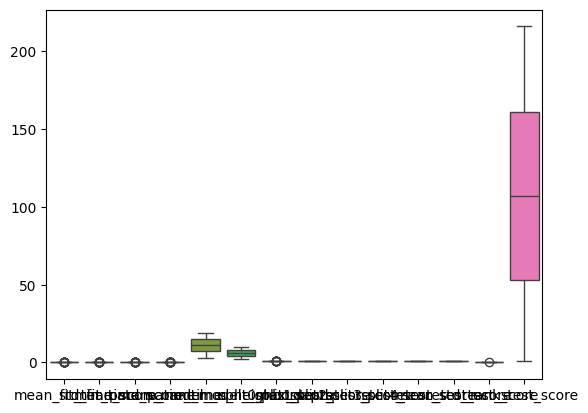

In [148]:
sns.boxplot(pd.DataFrame(grid.cv_results_))

## FunctionTransformer

Uso de FunctionTransformer para crear funciones personalizadas que usar en el pipeline


In [149]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

def log_transform(X):
    return np.log(X)
    # podemos usar aquí lo que queramos

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('log', FunctionTransformer(log_transform)), # este no da tan buen resultado
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsRegressor()) 
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(pipeline.named_steps)
print(r2_score(y_test, y_pred))

{'imputer': SimpleImputer(), 'log': FunctionTransformer(func=<function log_transform at 0x000001DE53FD6E80>), 'scaler': MinMaxScaler(), 'model': KNeighborsRegressor()}
0.8134498329740103


## ColumnTransformer

Separar y combinar pipelines para hacer distintos tratamientos a diferentes columnas

In [150]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [151]:
df = sns.load_dataset('penguins')
df = df.dropna(subset=['body_mass_g']) # quitar nulos de la salida "y" porque es la variable a predecir

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'species', 'island', 'sex']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [152]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
# pipeline numéricas
# quitamos la linea del modelo, aqui solo hacemos transformaciones numericas
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
pipeline_numerical = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', MinMaxScaler())
])

# pipeline categóricas
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
pipeline_categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False)) #, drop='first'))       
])

# unir pipelines con ColumnTransformer
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols),
    ('categorical', pipeline_categorical, categorical_cols)   
])

# pipeline final con el modelo
pipeline = make_pipeline(
    pipeline_all,
    KNeighborsRegressor(n_neighbors=7)    
)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index(['species', 'island', 'sex'], dtype='object'))])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=7))])

In [153]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#print(pipeline.named_steps)
print(r2_score(y_test, y_pred))

0.8387546470648246


## Remainder



In [154]:
'''# remainder: drop
pipeline_numerical = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', MinMaxScaler())
])

# pipeline categóricas
pipeline_categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False))      
])

# unir pipelines con ColumnTransformer
pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, ['bill_length_mm', 'bill_depth_mm']),
    ('categorical', pipeline_categorical, categorical_cols)   
], remainder='drop'                              
)

# pipeline final con el modelo
pipeline = make_pipeline(
    pipeline_all,
    KNeighborsRegressor(n_neighbors=7)    
)
pipeline'''

"# remainder: drop\npipeline_numerical = Pipeline([\n    ('imputer', KNNImputer(n_neighbors=7)),\n    ('scaler', MinMaxScaler())\n])\n\n# pipeline categóricas\npipeline_categorical = Pipeline([\n    ('imputer', SimpleImputer(strategy='most_frequent')),\n    ('encoder', OneHotEncoder(sparse_output=False))      \n])\n\n# unir pipelines con ColumnTransformer\npipeline_all = ColumnTransformer([\n    ('numeric', pipeline_numerical, ['bill_length_mm', 'bill_depth_mm']),\n    ('categorical', pipeline_categorical, categorical_cols)   \n], remainder='drop'                              \n)\n\n# pipeline final con el modelo\npipeline = make_pipeline(\n    pipeline_all,\n    KNeighborsRegressor(n_neighbors=7)    \n)\npipeline"

In [155]:
# remainder 'drop' (por defecto)
from sklearn.preprocessing import StandardScaler

pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),
    ('categorical', OneHotEncoder(), ['species', 'island'])
    ], remainder='drop'                              
)

pipeline
# 'flipper_length_mm' y 'sex' has sido eliminadas y no se han procesado
pd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()

,0,1,2,3,4,5,6,7
0,-0.240411,0.603547,1.0,0.0,0.0,1.0,0.0,0.0
1,-1.795331,0.502493,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.270998,-0.305938,1.0,0.0,0.0,0.0,1.0,0.0
3,1.350671,-0.406992,0.0,0.0,1.0,1.0,0.0,0.0
4,1.224108,0.098278,0.0,0.0,1.0,1.0,0.0,0.0


In [156]:
# remainder 'passthrough'
from sklearn.preprocessing import StandardScaler

pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),
    ('categorical', OneHotEncoder(), ['species', 'island'])
    ], remainder='passthrough'                              
)
# 'flipper_length_mm' y 'sex' se mantienen, pero no se han procesado, simplemente se agregan al resultado final
pd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.240411,0.603547,1.0,0.0,0.0,1.0,0.0,0.0,196.0,Male
1,-1.795331,0.502493,1.0,0.0,0.0,0.0,0.0,1.0,193.0,NaN
2,-1.270998,-0.305938,1.0,0.0,0.0,0.0,1.0,0.0,185.0,Female
3,1.350671,-0.406992,0.0,0.0,1.0,1.0,0.0,0.0,230.0,Male
4,1.224108,0.098278,0.0,0.0,1.0,1.0,0.0,0.0,228.0,Male


In [157]:
'''# remainder con un preprocesador:
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from sklearn.preprocessing import StandardScaler

pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),
    ], remainder=MinMaxScaler() # solo para casos con datos muy filtrados, separadas las numericas, etc                             
)

pipeline
# 'flipper_length_mm' y 'sex' se mantienen, pero no se han procesado, simplemente se agregan al resultado final
pd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()'''

"# remainder con un preprocesador:\nX = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]\ny = df['body_mass_g']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)\n\nfrom sklearn.preprocessing import StandardScaler\n\npipeline = ColumnTransformer([\n    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),\n    ], remainder=MinMaxScaler() # solo para casos con datos muy filtrados, separadas las numericas, etc                             \n)\n\npipeline\n# 'flipper_length_mm' y 'sex' se mantienen, pero no se han procesado, simplemente se agregan al resultado final\npd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()"

In [158]:
'''# remainder con un preprocesador:
from sklearn.preprocessing import StandardScaler

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

numerical_cols = X_train.select_dtypes(include=[np.number]).columns

pipeline_numerical1 = ColumnTransformer([
    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),
    ], remainder=MinMaxScaler() # solo para casos con datos muy filtrados, separadas las numericas, etc                             
)

pipeline
# 'flipper_length_mm' y 'sex' se mantienen, pero no se han procesado, simplemente se agregan al resultado final
pd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()'''

"# remainder con un preprocesador:\nfrom sklearn.preprocessing import StandardScaler\n\nX = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]\ny = df['body_mass_g']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)\n\nnumerical_cols = X_train.select_dtypes(include=[np.number]).columns\n\npipeline_numerical1 = ColumnTransformer([\n    ('numeric', StandardScaler(), ['bill_length_mm', 'bill_depth_mm']),\n    ], remainder=MinMaxScaler() # solo para casos con datos muy filtrados, separadas las numericas, etc                             \n)\n\npipeline\n# 'flipper_length_mm' y 'sex' se mantienen, pero no se han procesado, simplemente se agregan al resultado final\npd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()"

In [159]:
from sklearn.preprocessing import StandardScaler
# remainder con un preprocesador:
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


pipeline_numerical1 = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

pipeline_numerical2 = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', MinMaxScaler())
])

pipeline = ColumnTransformer([
        ('numeric', pipeline_numerical1, ['bill_length_mm', 'bill_depth_mm']),
    ], remainder=pipeline_numerical2
)
pipeline

ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                             KNNImputer(n_neighbors=7)),
                                            ('scaler', MinMaxScaler())]),
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=7)),
                                                 ('scaler', StandardScaler())]),
                                 ['bill_length_mm', 'bill_depth_mm'])])

In [160]:

# 'bill_length_mm', 'bill_depth_mm' se les aplica StandardScaler, y a 'flipper_length_mm'  se aplica MinMaxScaler
pd.DataFrame(pipeline.fit_transform(X_train, y_train)).head()

,0,1,2
0,-0.240411,0.603547,0.406780
1,-1.795331,0.502493,0.355932
2,-1.270998,-0.305938,0.220339
3,1.350671,-0.406992,0.983051
4,1.224108,0.098278,0.949153


## Transformador personalizado

(podemos crear nuestros transformadores pero heredando de una clase)

Para crear transformadores preprocesadores personalizados podemos crear una clase Python que herede de BaseEstimator, TransformerMixin


In [161]:
'''from sklearn.base import BaseEstimator, TransformerMixin

# Transformador personalizado para imprimir los datos e inspeccionarlos después de cada paso de un pipeline
class Debugger(BaseEstimator, TransformerMixin):
    
    def __init__(self, title, show_shape=True):
            self.title = title
            self.show_shape = show_shape

    def fit(self, X, y=None):
        # Normalmente aquí se aprende o se calculan parámetros a partir de los datos de entrada
        print(f'Ejecutando fit {self.title}')
        if self.show_shape:
            print(f'Shape de X: {X.shape}')
            print(f'X sample: {X[:1]}\n') # en lugar de poner X.head(), que si nos devuelve un array y no un dataframe de pandas nos daría error

        return self # Devuelve la instancia Debugger para encadenar en el Pipeline

       
    def transform(self, X):
        # aquí si que hay que devolver los datos transformados de la X
        X_copy = X.copy()
        # haremos las transformaciones sobre X_copy, para no cargarnos los datos originales
        print(f'Ejecutando transform {self.title}')
        if self.show_shape:
            # print(f'Shape de X: {X_copy.shape}')
            print(f'X sample {X_copy[:1]}\n') # Mostrar una fila
 
        return X_copy 
       
    # en realidad podríamos quitar esto, ya que antes ya estamos haciendo el fit y el transform     

    
    def fit_transform(self, X, y = None, **fit_params):
        print('fit_transform')
        return super().fit_transform(X, y, **fit_params)
    '''

"from sklearn.base import BaseEstimator, TransformerMixin\n\n# Transformador personalizado para imprimir los datos e inspeccionarlos después de cada paso de un pipeline\nclass Debugger(BaseEstimator, TransformerMixin):\n    \n    def __init__(self, title, show_shape=True):\n            self.title = title\n            self.show_shape = show_shape\n\n    def fit(self, X, y=None):\n        # Normalmente aquí se aprende o se calculan parámetros a partir de los datos de entrada\n        print(f'Ejecutando fit {self.title}')\n        if self.show_shape:\n            print(f'Shape de X: {X.shape}')\n            print(f'X sample: {X[:1]}\n') # en lugar de poner X.head(), que si nos devuelve un array y no un dataframe de pandas nos daría error\n\n        return self # Devuelve la instancia Debugger para encadenar en el Pipeline\n\n       \n    def transform(self, X):\n        # aquí si que hay que devolver los datos transformados de la X\n        X_copy = X.copy()\n        # haremos las transfo

    '''def fit_transform(self, X, y = None, **fit_params):
         return super().fit_transform(X, y, **fit_params)'''

In [162]:
#de Alan
from sklearn.base import BaseEstimator, TransformerMixin

# Transformador personalizado para imprimir los datos e inspeccionarlos después de cada paso de un pipeline
class Debugger(BaseEstimator, TransformerMixin):
    
    def __init__(self, title, show_shape=True):
        self.title = title
        self.show_shape = show_shape
        
    def fit(self, X, y=None):
        # Normalmente aquí se aprende o se calculan parámetros a partir de los datos de entrada
        print(f'Ejecutando fit {self.title}')
        if self.show_shape:
            print(f'Shape de X: {X.shape}')
            print(f'X sample: {X[:1]}\n') # Mostrar una fila
        
        return self # Devuelve la instancia Debugger para encadenar en el Pipeline
            
    
    def transform(self, X):
        X_copy = X.copy()
        # Aquí haríamos transformaciones sobre X_copy
        # print(f'Ejecutando transform {self.title}')
        # if self.show_shape:
        #     print(f'Shape de X: {X_copy.shape}')
        #     print(f'X sample: {X_copy[:1]}\n') # Mostrar una fila
        
        return X_copy

    
    def fit_transform(self, X, y = None, **fit_params):
        print('fit_transform')
        return super().fit_transform(X, y, **fit_params)
    

In [163]:
from sklearn.preprocessing import PowerTransformer

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

pipeline = Pipeline([
    # transformaciones
    ('debug1', Debugger(title='Datos X sin procesar')),
    
    ('imputer', SimpleImputer()),
    ('debug2', Debugger(title='Datos X tras SimpleImputer')),
    
    ('transformer', PowerTransformer()), 
    ('debug3', Debugger(title='Datos X tras PowerTransformer')),
   
    ('scaler', MinMaxScaler()), 
    ('debug4', Debugger(title='Datos X tras MinMaxScaler')),

    ('model', KNeighborsRegressor()) # modelo predictor
])

pipeline.fit(X_train, y_train) # resultado: un modelo entrenado con datos preprocesados


fit_transform
Ejecutando fit Datos X sin procesar
Shape de X: (273, 3)
X sample:      bill_length_mm  bill_depth_mm  flipper_length_mm
115            42.7           18.3              196.0

fit_transform
Ejecutando fit Datos X tras SimpleImputer
Shape de X: (273, 3)
X sample: [[ 42.7  18.3 196. ]]

fit_transform
Ejecutando fit Datos X tras PowerTransformer
Shape de X: (273, 3)
X sample: [[-0.22916448  0.58947392 -0.30358024]]

fit_transform
Ejecutando fit Datos X tras MinMaxScaler
Shape de X: (273, 3)
X sample: [[0.39914212 0.59376449 0.50336414]]



Pipeline(steps=[('debug1', Debugger(title='Datos X sin procesar')),
                ('imputer', SimpleImputer()),
                ('debug2', Debugger(title='Datos X tras SimpleImputer')),
                ('transformer', PowerTransformer()),
                ('debug3', Debugger(title='Datos X tras PowerTransformer')),
                ('scaler', MinMaxScaler()),
                ('debug4', Debugger(title='Datos X tras MinMaxScaler')),
                ('model', KNeighborsRegressor())])

In [164]:
# X_test será preprocesado por los pasos del pipeline antes de llegar al modelo
pipeline.predict(X_test)


array([4770., 4140., 3890., 3960., 3965., 4355., 4255., 3565., 5440.,
       3980., 4145., 4945., 4700., 5110., 3340., 3600., 4110., 3495.,
       3540., 3245., 3565., 3500., 4460., 3300., 4020., 3915., 4110.,
       3610., 3485., 5010., 4025., 3670., 4050., 4480., 4055., 3710.,
       4015., 4945., 4055., 3870., 4110., 3750., 5600., 5270., 3700.,
       3490., 5510., 5490., 3325., 3265., 4800., 3530., 4800., 3690.,
       3350., 3645., 3160., 5550., 5760., 3960., 4540., 5440., 5300.,
       5365., 3400., 3855., 3470., 4185., 4230.])

## Transformador personalizado para outliers

In [165]:
class OutlierToNaN(BaseEstimator, TransformerMixin):
    """
    Reemplaza valores outliers por NaN usando el método IQR de Tukey
    Funciona con DataFrames de pandas o arrays NumPy
    """
    def __init__(self, factor=1.5):
        self.factor = factor
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.is_df_ = True
            self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns
            Q1 = X[self.numeric_cols_].quantile(0.25)
            Q3 = X[self.numeric_cols_].quantile(0.75)
        else:
            self.is_df_ = False
            Q1 = np.percentile(X, 25, axis=0)
            Q3 = np.percentile(X, 75, axis=0)
        
        IQR = Q3 - Q1
        self.lower_bounds_ = Q1 - (self.factor * IQR)
        self.upper_bounds_ = Q3 + (self.factor * IQR)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.is_df_:
            numeric_data = X_copy[self.numeric_cols_]
            outlier_mask = (numeric_data < self.lower_bounds_) | (numeric_data > self.upper_bounds_)
            X_copy[self.numeric_cols_] = numeric_data.mask(outlier_mask, np.nan)
            return X_copy
        else:
            outlier_mask = (X_copy < self.lower_bounds_) | (X_copy > self.upper_bounds_)
            X_copy[outlier_mask] = np.nan
            return X_copy

In [166]:
'''# Clase que elimina los outliers, se puede crear una variante que simplemente los reemplace por nan 
class OutlierRemover(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor=1.5):
        self.factor = factor # factor para calcular umbrales inferior y superior (método tukey)
        
    def fit(self, X, y=None):
        # por si no viene como dataframe:
 #       if not isinstance(X, pd.DataFrame):
 #           X = pd.DataFrame(X)
            
        # se supone que nos van a pasar columnas numéricas, pero por si acaso.,
        self.numerical_cols_ = X.select_dtypes(include=[np.number]).columns
        # de momento no quitamos ouliers, solo hacemos calculos sobre los datos
 #       Q1 = X[self.numerical_cols_].quantile(0.25) # si no tenemos un dataframe tenemos que usar un metodo numpy
 #       Q3 = X[self.numerical_cols_].quantile(0.75)
        Q1 = np.percentile(X, 25, axis=0) # solo con nmumpoy, sin pandas
        Q3 = np.percentile(X, 75, axis=0)

        IQR = Q3 - Q1

        # cálculo de límites
        self.lower_bound_ = Q1 - self.factor * IQR
        self.upper_bound_ = Q3 + self.factor * IQR
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
#        filtro = ~((X_copy[self.numerical_cols_] < self.lower_bound_) | (X_copy[self.numerical_cols_] > self.upper_bound_)).any(axis=1)
        filtro = np.all((X_copy >= self.lower_bound_) & (X <= self.upper_bound_), axis=1)
        return X_copy[filtro]
    '''

'# Clase que elimina los outliers, se puede crear una variante que simplemente los reemplace por nan \nclass OutlierRemover(BaseEstimator, TransformerMixin):\n    \n    def __init__(self, factor=1.5):\n        self.factor = factor # factor para calcular umbrales inferior y superior (método tukey)\n        \n    def fit(self, X, y=None):\n        # por si no viene como dataframe:\n #       if not isinstance(X, pd.DataFrame):\n #           X = pd.DataFrame(X)\n            \n        # se supone que nos van a pasar columnas numéricas, pero por si acaso.,\n        self.numerical_cols_ = X.select_dtypes(include=[np.number]).columns\n        # de momento no quitamos ouliers, solo hacemos calculos sobre los datos\n #       Q1 = X[self.numerical_cols_].quantile(0.25) # si no tenemos un dataframe tenemos que usar un metodo numpy\n #       Q3 = X[self.numerical_cols_].quantile(0.75)\n        Q1 = np.percentile(X, 25, axis=0) # solo con nmumpoy, sin pandas\n        Q3 = np.percentile(X, 75, axis=0

In [167]:
# de Alan, solo para numpy
class OutlierRemover(BaseEstimator, TransformerMixin):
    
    def __init__(self, factor=1.5):
        self.factor = factor # factor para calcular umbrales inferior y superior (método tukey)
        
    def fit(self, X, y=None):
        # if not isinstance(X, pd.DataFrame):
        #     X = pd.DataFrame(X)
            
        # self.numerical_cols_ = X.select_dtypes(include=[np.number]).columns
        
        # Q1 = X.quantile(0.25)
        # Q3 = X.quantile(0.75)
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        
        # cálculo de límites
        self.lower_bound_ = Q1 - self.factor * IQR
        self.upper_bound_ = Q3 + self.factor * IQR
        return self
    def transform(self, X):
        X_copy = X.copy()
        
        #filtro = ~((X_copy < self.lower_bound_) | (X_copy > self.upper_bound_)).any(axis=1)
        filtro = np.all((X_copy >= self.lower_bound_) & (X <= self.upper_bound_), axis=1)
        return X_copy[filtro]

In [168]:
# comprobar     que funciona usando un factor pequeño para ver si quita outliers
remover = OutlierRemover(factor=0.5)
remover.fit_transform(X_train)

,bill_length_mm,bill_depth_mm,flipper_length_mm
115,42.7,18.3,196.0
138,37.0,16.5,185.0
301,52.5,15.6,221.0
78,36.2,16.1,187.0
211,45.6,19.4,194.0
...,...,...,...
21,37.7,18.7,180.0
72,39.6,17.2,196.0
107,38.2,20.0,190.0
271,48.5,14.1,220.0


In [169]:
df = sns.load_dataset('penguins')
df = df.dropna(subset=['body_mass_g']) 

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = df['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [170]:
pipeline = make_pipeline(
    OutlierToNaN(factor=0.9),
    Debugger(title='X after OutlierRemover'),
    
    SimpleImputer(),
    Debugger(title='X after SimpleImputer'),
    
    PowerTransformer(),
    Debugger(title='X after PowerTransformer'),
    
    MinMaxScaler(), 
    Debugger(title='X after MinMaxScaler'),

    KNeighborsRegressor(), 
)
pipeline.fit(X_train, y_train)

fit_transform
Ejecutando fit X after OutlierRemover
Shape de X: (273, 3)
X sample:      bill_length_mm  bill_depth_mm  flipper_length_mm
115            42.7           18.3              196.0

fit_transform
Ejecutando fit X after SimpleImputer
Shape de X: (273, 3)
X sample: [[ 42.7  18.3 196. ]]

fit_transform
Ejecutando fit X after PowerTransformer
Shape de X: (273, 3)
X sample: [[-0.23801431  0.60102745 -0.30358024]]

fit_transform
Ejecutando fit X after MinMaxScaler
Shape de X: (273, 3)
X sample: [[0.43274042 0.6126488  0.50336414]]



Pipeline(steps=[('outliertonan', OutlierToNaN(factor=0.9)),
                ('debugger-1', Debugger(title='X after OutlierRemover')),
                ('simpleimputer', SimpleImputer()),
                ('debugger-2', Debugger(title='X after SimpleImputer')),
                ('powertransformer', PowerTransformer()),
                ('debugger-3', Debugger(title='X after PowerTransformer')),
                ('minmaxscaler', MinMaxScaler()),
                ('debugger-4', Debugger(title='X after MinMaxScaler')),
                ('kneighborsregressor', KNeighborsRegressor())])

TO DO revisar anteriores

## Transformador personalizado para crear nuevas features

Ejemplo para crear una nueva columna en el dataset titanic

Tenemos que ver los que tenmos, porque algunos están preprocesados y otros no

sibsp + parch + 1 = family_size
(hermanos, pareja) + (padres, hijos)

In [171]:
sns.load_dataset('titanic').head(1)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.25,S,Third,man,True,NaN,Southampton,no,False


In [172]:
df = sns.load_dataset('titanic')
X = df.drop('alive', axis=1)
y = df['alive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Estamos dando por hecho que trabajamos con un dataframe

In [173]:
class FamilySizeFeature(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fir_params):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['family_size'] = X_copy['sibsp'] + X_copy['parch'] + 1
        return X_copy
    
    # faltaria agregar el SimpleImputer etc

In [174]:
pipeline = make_pipeline(
    FamilySizeFeature(),
    # agregar más pasos por ejemplo un column transformer con un pipeline para numéricas y otro pipeline para categóricas
    # agregar modelo
)
pipeline.fit_transform(X_train, y_train) # comprobar que aparece una nueva columna family_size

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone,family_size
331,0,1,male,45.5,0,0,28.5000,S,First,man,True,C,Southampton,True,1
733,0,2,male,23.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,True,1
382,0,3,male,32.0,0,0,7.9250,S,Third,man,True,NaN,Southampton,True,1
704,0,3,male,26.0,1,0,7.8542,S,Third,man,True,NaN,Southampton,False,2
813,0,3,female,6.0,4,2,31.2750,S,Third,child,False,NaN,Southampton,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,3,female,21.0,0,0,7.6500,S,Third,woman,False,NaN,Southampton,True,1
270,0,1,male,NaN,0,0,31.0000,S,First,man,True,NaN,Southampton,True,1
860,0,3,male,41.0,2,0,14.1083,S,Third,man,True,NaN,Southampton,False,3
435,1,1,female,14.0,1,2,120.0000,S,First,child,False,B,Southampton,False,4


In [175]:
pipeline.transform(X_test) # comprobar que aparece una nueva columna family_size

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone,family_size
709,1,3,male,NaN,1,1,15.2458,C,Third,man,True,NaN,Cherbourg,False,3
439,0,2,male,31.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,True,1
840,0,3,male,20.0,0,0,7.9250,S,Third,man,True,NaN,Southampton,True,1
720,1,2,female,6.0,0,1,33.0000,S,Second,child,False,NaN,Southampton,False,2
39,1,3,female,14.0,1,0,11.2417,C,Third,child,False,NaN,Cherbourg,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,0,3,male,17.0,0,0,7.1250,S,Third,man,True,NaN,Southampton,True,1
773,0,3,male,NaN,0,0,7.2250,C,Third,man,True,NaN,Cherbourg,True,1
25,1,3,female,38.0,1,5,31.3875,S,Third,woman,False,NaN,Southampton,False,7
84,1,2,female,17.0,0,0,10.5000,S,Second,woman,False,NaN,Southampton,True,1


## Feature Selection en pipelines

In [176]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer() # clasificación binaria
df = pd.DataFrame(data.data, columns = data.feature_names)
X = df 
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
# con feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier

pipeline = make_pipeline(
    OutlierToNaN(factor=0.9),
    Debugger(title='X after OutlierRemover'),
    
    SimpleImputer(strategy='median'),
    Debugger(title='X after SimpleImputer'),
    
    SelectKBest(f_classif, k=10),
    Debugger(title='X after SelectKBest'),
        
    PowerTransformer(),
    Debugger(title='X after PowerTransformer'),
    
    MinMaxScaler(), 
    Debugger(title='X after MinMaxScaler'),

    KNeighborsClassifier(), 
)
pipeline.fit(X_train, y_train)
pipeline.predict(X_test)

fit_transform
Ejecutando fit X after OutlierRemover
Shape de X: (455, 30)
X sample:     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
68        9.029         17.33           58.79      250.5           0.1066   

    mean compactness  mean concavity  mean concave points  mean symmetry  \
68            0.1413             NaN              0.04375         0.2111   

    mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
68                     NaN  ...         10.31          22.65             65.5   

    worst area  worst smoothness  worst compactness  worst concavity  \
68       324.7            0.1482             0.4365              NaN   

    worst concave points  worst symmetry  worst fractal dimension  
68                 0.175             NaN                      NaN  

[1 rows x 30 columns]

fit_transform
Ejecutando fit X after SimpleImputer
Shape de X: (455, 30)
X sample: [[9.0290e+00 1.7330e+01 5.8790e+01 2.5050e+02 1.0660e-01 

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0])

## FeatureUnion

FeatureUnion: ejecuta transformaciones en paralelo a los mismos datos de entrada X, las salidas del Feature Union se concatenan.

Útil para aplicar transformaciones a columnas diferentes que son independientes en paralelo, por ejemplo calcular algo sobre una columna modificandola o creando otra nueva, crear una nueva columna a partir de otras.

ColumnTransformer: indica transformaciones concretas para columnas específicas. (Más habitual)


In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

make_pipeline(
    OutlierToNaN(),
    SimpleImputer(),
    StandardScaler(),
    # FeatureUnion([ 
    #     # Ejemplo demostrativo 1: no es habitual juntar dos técnicas de reducción de dimensionalidad
    #     ('feature_selection', SelectKBest(k=10)),
    #     ('pca', PCA(n_components=3)),
        
    #     # Ejemplo demostrativo 2: no es habitual juntar dos técnicas de reducción de dimensionalidad
    #     ('pca', PCA(n_components=3)),
    #     ('poly', PolynomialFeatures(degree=2)), # introduce no linealidad ayuda a capturar mejor las relaciones no lineales como curvas
        
    #     # Ejemplo 3:
    #     Column1CustomTransformer(), # transformador personalizado para tratar una columna concreta y que no depende de las demás
    #     Column2CustomTransformer(), # transformador personalizado para tratar una columna concreta y que no depende de las demás
    #     Column3CustomTransformer(), # transformador personalizado para tratar una columna concreta y que no depende de las demás
    # ]),
    LogisticRegression()
)

Pipeline(steps=[('outliertonan', OutlierToNaN()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Exportar con joblib

Exportar con joblib y volver a cargar y comprobar que funciona para realizar predicciones.

Ver ejemplo de despliegue en GCP sobre pdf con capturas.

In [179]:
df = sns.load_dataset('penguins')
df = df.dropna(subset=['body_mass_g']) # Quitar nulos de la salida "y" porque es la variable a predecir

X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'species', 'island', 'sex']]
y = df['body_mass_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [180]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline


numerical_cols = X_train.select_dtypes(include=[np.number]).columns
pipeline_numerical = make_pipeline([
    KNNImputer(n_neighbors=7),
    MinMaxScaler(), 
])

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
pipeline_categorical = make_pipeline([
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False)
])

pipeline_all = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols),
    ('categorical', pipeline_categorical, categorical_cols)
])

pipeline = make_pipeline(
    pipeline_all,
    KNeighborsRegressor(n_neighbors=7)
)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('list',
                                                                   [KNNImputer(n_neighbors=7),
                                                                    MinMaxScaler()])]),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('list',
                                                                   [SimpleImputer(strategy='most_frequent'),
                                                                    OneHotEncoder(sparse_output=False)])]),
                                                  Index(['species', 'island', 'sex'], dtype='object'))])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=7))])

In [181]:
from joblib import dump, load

In [182]:
# exportar el modelo
dump(pipeline, 'pipeline_penguins_regresion.joblib')

['pipeline_penguins_regresion.joblib']

In [183]:
# importar el modelo
# este load lo haríamos en una aplicación web con Python para desplegar en un servidor
pipeline = load('pipeline_penguins_regresion.joblib')

In [184]:
pipeline.predict(X_test)

NotFittedError: Pipeline is not fitted yet.